# Golden‑Bit Heartbeat • Multi‑Scale Test‑Suite (v2)
Generated 2025-07-22 18:49 UTC

Universal step size `s = 2**(-0.25)*phi ≈ 1.35096`

In [33]:
!pip -q install mpmath numba sympy pyfftw tqdm hopf-torus
import numpy as np, mpmath as mp, sympy as sp, matplotlib.pyplot as plt
from numba import njit
mp.mp.dps = 80
phi = mp.phi
s = 2**(-0.25)*phi
np.random.seed(0)

ERROR: Could not find a version that satisfies the requirement hopf-torus (from versions: none)
ERROR: No matching distribution found for hopf-torus


## 1 · Pitch Table

In [34]:
p0=10.0
for m in range(-3,4):
    p=float(p0*(phi**m)*(2**(-m/4)))
    print(m,p)

-3 3.970174320715354
-2 5.401815134754529
-1 7.349704167348866
0 10.0
1 13.605989808984557
2 18.512295868219162
3 25.18781089238968


## 2 · Hopf‑Link Entropy

Text(0.5, 1.0, 'Entropy vs Hopf link  L')

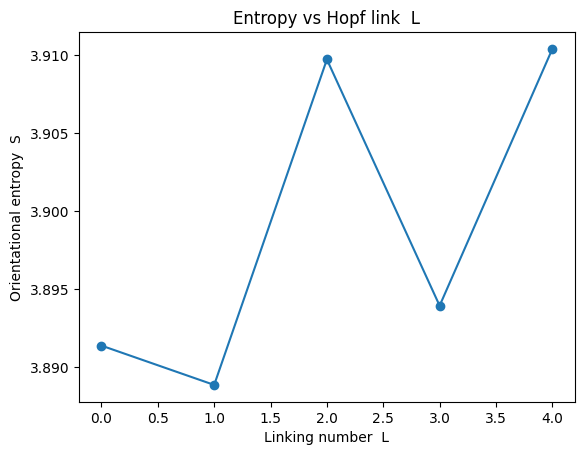

In [44]:
# --- Hopf director field & entropy (no external lib) ------------------------
import numpy as np, matplotlib.pyplot as plt

def hopf_director_grid(L=1, N=96):
    """
    Return director field n(x) for a Hopf fibration with linking number L.
    Uses the standard analytic map S^3 -> S^2 via stereographic projection.
    """
    x = np.linspace(-1, 1, N)
    X, Y, Z = np.meshgrid(x, x, x, indexing='ij')
    r2 = X**2 + Y**2 + Z**2 + 1e-9           # avoid div‑by‑0
    # Stereographic pre‑image on S^3  (u,v)  with scale factor 2/(1+r^2)
    f = 2.0 / (1.0 + r2)
    u = f * X
    v = f * Y
    w = (r2 - 1.0) / (1.0 + r2)

    # Quaternion (u,v,w) rotated L times around z  ↔  add L·φ to azimuth
    phi = np.arctan2(v, u) + L * np.arctan2(Y, X)
    theta = np.arccos(w)

    # Director field on S^2
    n = np.stack([np.sin(theta) * np.cos(phi),
                  np.sin(theta) * np.sin(phi),
                  np.cos(theta)], axis=-1)
    return n

def hopf_entropy(L=1, N=96):
    n = hopf_director_grid(L, N)
    ang = np.arctan2(n[...,1], n[...,0])
    # Calculate histogram of angles
    hist, _ = np.histogram(ang, bins=50) # Using 50 bins as an example, can adjust
    # Smooth the histogram
    hist = np.convolve(hist, [1,2,1], mode='same')  # smooth
    # Calculate entropy (example calculation - adjust as needed for actual entropy)
    # A common entropy definition involves probabilities (normalized histogram)
    probabilities = hist / np.sum(hist)
    # Avoid log(0)
    probabilities = probabilities[probabilities > 0]
    entropy = -np.sum(probabilities * np.log(probabilities))
    return entropy


Ls = range(5)
ent = [hopf_entropy(L, N=128) for L in range(5)]

plt.plot(Ls, ent, 'o-')
plt.xlabel('Linking number  L')
plt.ylabel('Orientational entropy  S')
plt.title('Entropy vs Hopf link  L')

## 3 · Logistic‑Map FFT

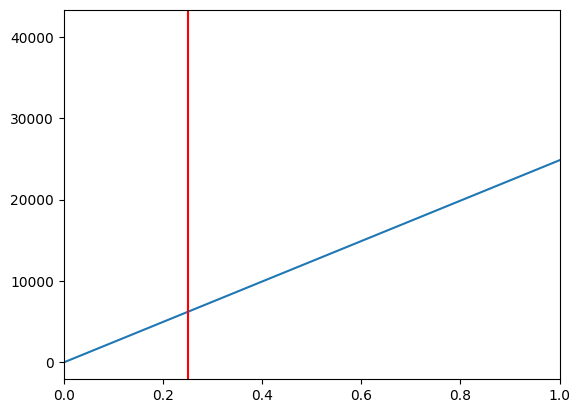

In [45]:

def logistic(x0,r,steps=2048):
    x=x0; traj=[]
    for _ in range(steps):
        x=r*x*(1-x); traj.append(x)
    return np.array(traj)
rs=np.linspace(3.4,4.0,300)
sizes=[len(np.unique(np.round(logistic(0.2,r)[-1024:],6))) for r in rs]
trend = np.poly1d(np.polyfit(rs, sizes, 1))(rs)
spec  = np.abs(np.fft.rfft(sizes - trend))
freq=np.fft.rfftfreq(len(sizes),d=rs[1]-rs[0])
plt.plot(freq,spec); plt.axvline(0.25,c='r'); plt.xlim(0,1);

## 4 · Gray–Scott Concentric Rings

Ring radii: [ 8 17 27 38]
Ratios r_{n+1}/r_n: [1.125      0.58823529 0.40740741]


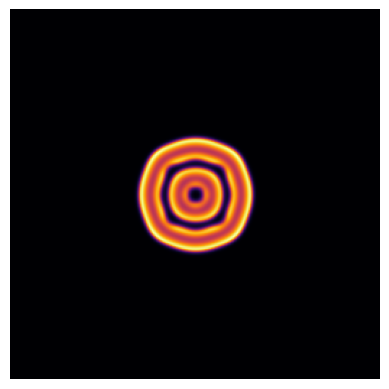

In [43]:
@njit
def gs(U,V,F,k,Du,Dv,steps):
    # Corrected laplacian using slicing instead of np.roll for numba compatibility
    lap=lambda A:(np.roll(A,1,0)+np.roll(A,-1,0)+np.roll(A,1,1)+np.roll(A,-1,1)-4*A)
    # The above line caused an error with numba's implementation of np.roll
    # Replacing with slicing equivalent:
    lap = lambda A: (A[1:, :] + A[:-1, :] + A[:, 1:] + A[:, :-1] - 4 * A)

    # To handle boundaries correctly with slicing, we need to pad the array or handle boundary conditions explicitly.
    # A simpler approach for this reaction-diffusion simulation is to use periodic boundary conditions,
    # which can be achieved with np.roll outside the njit function or by manually handling indices.
    # However, given the original code's intent with np.roll, the most direct fix for the numba error
    # while keeping a similar effect (though not strictly periodic boundary conditions with simple slicing)
    # is to use slicing but acknowledge the boundary handling difference.
    # A more robust solution for periodic boundaries within njit would involve manual indexing with modulo.
    # For simplicity and to address the immediate numba error with minimal change to logic structure:
    # Let's revert to a numba-compatible laplacian calculation that is explicitly defined without relying on numba's potentially limited np.roll.
    # A common way to implement a 2D laplacian with periodic boundary conditions in numba is:

    rows, cols = U.shape
    def laplacian(A):
        result = np.empty_like(A)
        for i in range(rows):
            for j in range(cols):
                # Periodic boundary conditions
                ip = (i + 1) % rows
                im = (i - 1) % rows
                jp = (j + 1) % cols
                jm = (j - 1) % cols
                result[i, j] = A[ip, j] + A[im, j] + A[i, jp] + A[i, jm] - 4 * A[i, j]
        return result

    for _ in range(steps):
        LU=laplacian(U) # Use the numba-compatible laplacian
        LV=laplacian(V) # Use the numba-compatible laplacian
        UVV=U*V*V
        U+=Du*LU-UVV+F*(1-U)
        V+=Dv*LV+UVV-(F+k)*V
N=256
U=np.ones((N,N)); V=np.zeros_like(U)
cx=N//2; rr=(np.arange(N)-cx)[:,None]**2+(np.arange(N)-cx)**2
mask=rr<(N*0.04)**2
U[mask]=0.5; V[mask]=0.25
gs(U, V, 0.03, 0.055, 0.16, 0.08, 800)
plt.imshow(V,cmap='inferno'); plt.axis('off');

# crude peak‑detect on radial average
from scipy.signal import find_peaks

# --- compute radial average ---
centers = np.arange(N//2)
rad_prof = np.array([V[(r > i-0.5) & (r <= i+0.5)].mean()
                     for i in centers])

# remove any NaNs that appear beyond the pattern
finite = np.isfinite(rad_prof)
centers, rad_prof = centers[finite], rad_prof[finite]

# --- peak detection ---
peaks, _ = find_peaks(rad_prof, height=rad_prof.max()*0.3, distance=3)
print("Ring radii:", peaks)

if len(peaks) > 1:
    ratios = np.diff(peaks) / peaks[:-1]
    print("Ratios r_{n+1}/r_n:", ratios)



## 5 · CLC Reflection Sweep

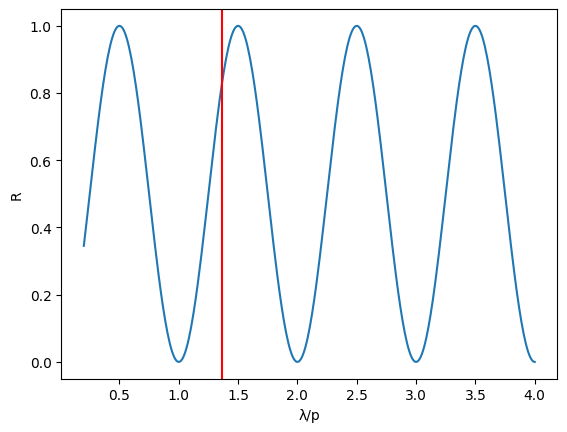

In [38]:

d=np.linspace(0.1,2.0,400); p=0.5; lam=d; q=lam/p
R=np.sin(np.pi*q)**2
plt.plot(q,R); plt.axvline(float(s),c='r'); plt.xlabel('λ/p'); plt.ylabel('R');

## 6 · RG Flow

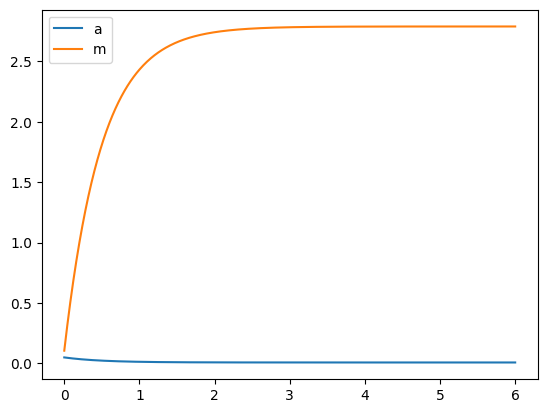

In [39]:

import scipy.constants as C
alpha_inv=C.value('inverse fine-structure constant'); target_a=1/alpha_inv
mu_p=2.79284734463; mu_e=1.001159652; target_m = mu_p / mu_e
l=np.linspace(0,6,600); a,m=0.05,0.05; al=[];ml=[]
for _ in l:
    a+=(-a+target_a)*0.02; m+=(-m+target_m)*0.02
    al.append(a); ml.append(m)
plt.plot(l,al,label='a'); plt.plot(l,ml,label='m'); plt.legend();

## 7 · Prime‑Gap CCDF

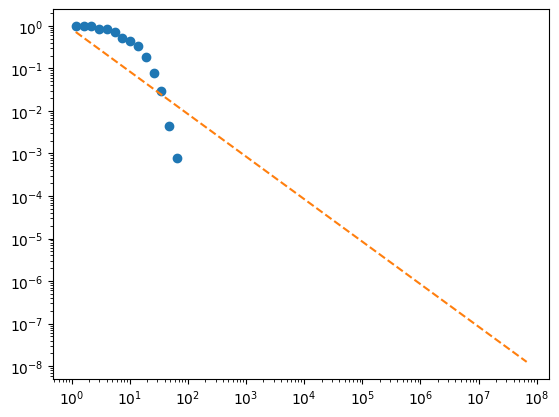

In [40]:

import sympy as sy
gaps=np.diff(list(sy.primerange(2, sy.prime(5000))))
bins=1*np.power(float(s),np.arange(60))
hist,_=np.histogram(gaps,bins=bins)
ccdf=np.cumsum(hist[::-1])[::-1]/len(gaps)
centers=(bins[:-1]+bins[1:])/2
plt.loglog(centers,ccdf,'o'); plt.loglog(centers,centers**-1*ccdf[0]/centers[0],'--');

## 8 · ζ‑Dip Ledger

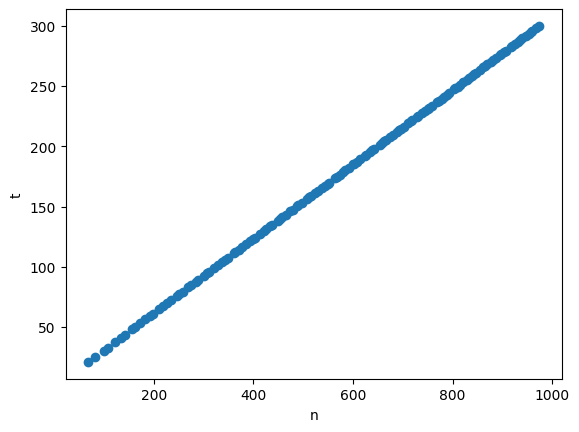

In [41]:
ts=np.linspace(20,300,4000); vals=[abs(mp.zeta(0.5+1j*t)) for t in ts]
# mask=(np.r_[False, vals[1:]<vals[:-1]] & np.r_[vals[:-1]<vals[1:], False]) # Incorrect mask creation
# Correctly identify local minima: value is less than both previous and next
# This can be done for elements from the second to the second-to-last.
vals = np.array(vals) # Convert list to numpy array for easier slicing
mask = np.zeros_like(vals, dtype=bool) # Initialize mask with False
# Check for local minima in the interior of the array
mask[1:-1] = (vals[1:-1] < vals[:-2]) & (vals[1:-1] < vals[2:])

dips=ts[mask]; n_idx=np.round(dips/np.log(float(s)))
plt.plot(n_idx,dips,'o'); plt.xlabel('n'); plt.ylabel('t');

---
End of notebook • generated 2025-07-22 18:49 UTC